<a href="https://colab.research.google.com/github/aptr288/Claim_prediction/blob/master/Claim_Prediction_Codebase_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Insurance claim prediction.



Libraries downloaded and imported. 


In [25]:
!pip install pandas

In [0]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import  svm,  tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor 
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import os
from google.colab import drive

Mounting Google drive to work with files uploaded to Gdrive

In [27]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Trupanion/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Pet data into dataframe

In [28]:
pet_data_df = pd.read_csv('petdata.csv', delimiter=',', header = 'infer')
pet_data_df.head(5)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old
3,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1 year old
4,4,2014-07-20,NaN,Cat,Mixed Breed,8 weeks to 12 months old


Loading Claim data into dataframe

In [29]:
claim_data_df = pd.read_csv('claimdata.csv', delimiter=',', header= 'infer')
claim_data_df.head(5)

,ClaimId,PetId,ClaimDate,ClaimAmount
0,0,9273,2014-02-25,389.65
1,1,1988,2014-03-10,455.40
2,2,2452,2014-04-02,1953.79
3,3,3658,2014-04-05,243.74
4,5,9147,2014-03-18,206.42


Converting dates from string fromat to datetime

In [0]:
pet_data_df['EnrollDate'] =  pd.to_datetime(pet_data_df['EnrollDate'], format='%Y-%m-%d')
pet_data_df['CancelDate'] =  pd.to_datetime(pet_data_df['CancelDate'], format='%Y-%m-%d')
claim_data_df['ClaimDate'] =  pd.to_datetime(claim_data_df['ClaimDate'], format='%Y-%m-%d')

**Joining pet data with claim data, left joined to capture each claim per pet**

In [84]:
claim_data_per_pet = pd.merge(pet_data_df, claim_data_df, how='left' , on = 'PetId')
#replacing Nan value with zero
claim_data_per_pet['ClaimAmount'].fillna(0, inplace=True)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61


# Feature Engineering 

Extracted features out of exiting ones to better expose the data to train the model.

Total claim amount and claim count for each pet

In [0]:
#User defined function to correct claim count to zero using claim date 
def get_claims_count(ClaimsCount,claim_date):
  if (claim_date is pd.NaT):
    return 0
  else:
    return ClaimsCount

In [85]:
#Total sum of claim amount per pet id
total_claim_amount_per_petid = claim_data_per_pet.groupby('PetId')[['ClaimAmount']].sum()
total_claim_amount_per_petid = total_claim_amount_per_petid.rename(columns = {"PetId": "PetId",  "ClaimAmount": "TotalClaimedAmount"})

#Total count of claims done for each pet id
total_num_cliams_per_petid = claim_data_per_pet.groupby('PetId')[['ClaimAmount']].count()
total_num_cliams_per_petid = total_num_cliams_per_petid.rename(columns = {"PetId": "PetId",  "ClaimAmount": "ClaimsCountIntermediate" })
extracted_features = pd.merge(total_claim_amount_per_petid, total_num_cliams_per_petid, how='inner' , on = 'PetId')
claim_data_per_pet = pd.merge(claim_data_per_pet, extracted_features, how='left' , on = 'PetId')
claim_data_per_pet['ClaimsCountRevised'] = claim_data_per_pet.apply(lambda x: get_claims_count(x.ClaimsCountIntermediate, x.ClaimDate), axis=1)
claim_data_per_pet.drop(['ClaimsCountIntermediate'],inplace=True, axis=1)
extracted_features.drop(['ClaimsCountIntermediate'],inplace=True, axis=1)
#Features extracted are clubed into extracted_features data frame
claims_count_revised = claim_data_per_pet.loc[:, ('PetId', 'ClaimsCountRevised')] #claim_data_per_pet.loc([['PetId', 'ClaimsCountRevised']])
claims_count_revised.drop_duplicates(subset ="PetId", keep = "first", inplace = True)
extracted_features = pd.merge(extracted_features, claims_count_revised, how='inner' , on = 'PetId')
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountRevised
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00,0.00,0
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00,0.00,0
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80,2643.44,14
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69,2643.44,14
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61,2643.44,14


Insurance Period, Claim frequency for each month and feature to indicate if insurance is Cancelled 

In [0]:
#Calculate insurance period using enroll date and cancel date or if insurance is not cancelled, then calculte period till given date 2019-07 
def get_insured_period(enrolled,cancelled):
  if (cancelled is pd.NaT):
    return abs(enrolled - pd.Timestamp('2019-07-01')).days
  else:
    return abs(enrolled - cancelled).days

In [90]:
#Number of years insured 
extracted_features['InsurancedPeriod'] = pet_data_df.apply(lambda x: get_insured_period(x.EnrollDate, x.CancelDate)/365, axis=1)
#Frequency of claims per month while insured 
extracted_features['ClaimFreqPerMonth'] = (extracted_features['ClaimsCountRevised']*30)/extracted_features['InsurancedPeriod']
#Feature indicationg if the Insurance is cancelled or not 
extracted_features['InsuranceCancelled'] = pet_data_df['CancelDate'].apply(lambda x: 1 if x is pd.NaT  else 0)
extracted_features.head()

,PetId,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled
0,0,0.00,0,2.923288,0.000000,0
1,1,0.00,0,1.942466,0.000000,0
2,2,2643.44,14,4.531507,92.684401,1
3,3,0.00,0,0.013699,0.000000,0
4,4,1356.79,1,4.950685,6.059768,1


In [91]:
#Extract claim year, month and day from datetime object 
claim_data_per_pet['ClaimYear'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).year.fillna(0)
claim_data_per_pet['ClaimMonth'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).month.fillna(0)
claim_data_per_pet['ClaimlDay'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).day.fillna(0)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountRevised,ClaimYear,ClaimMonth,ClaimlDay
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80,2643.44,14,2018.0,2.0,14.0
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69,2643.44,14,2018.0,8.0,7.0
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61,2643.44,14,2018.0,4.0,14.0


In [0]:
#Converting the age at enrolled to years accordingly in numeric 
#['5 years old' '3 years old' '8 weeks to 12 months old' '1 year old', '4 years old' '7 years old' '10 years old' '9 years old' '2 years old', '8 years old' '6 years old' '11 years old' '0-7 weeks old' '13 years old', '12 years old']
def age_conversion_to_numeric(df):
  age_values_at_enrolled = df.AgeAtEnroll.unique()
  # "8 weeks to 12 months old" is converted to 0.5 years approximatly and '0-7 weeks old' to 0.08 years 
  age_converted = [5,3,0.5,1,4,7,10,9,2,8,6,11,0.08,13,12]
  for i in range(len(age_values_at_enrolled)):
    df['AgeAtEnroll'].replace(to_replace = age_values_at_enrolled[i], value = age_converted[i] , inplace=True)

In [0]:
#Calculate the age of pet when claim is registered
def get_age_at_claim(ClaimDate,EnrollDate, AgeAtEnroll):
    if (ClaimDate is pd.NaT):
      #if there is no claim registered then  return the existing age when enrolled 
      return float(AgeAtEnroll)
    else:
     return float((ClaimDate - EnrollDate).days/365 + AgeAtEnroll)

In [42]:
#Again when claim is raised
age_conversion_to_numeric(claim_data_per_pet)
claim_data_per_pet['AgeAtClaim'] = claim_data_per_pet.apply(lambda x: get_age_at_claim(x.ClaimDate, x.EnrollDate, x.AgeAtEnroll), axis=1)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,ClaimYear,ClaimMonth,ClaimlDay,AgeAtClaim
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,NaN,NaT,0.00,0.00,1,0,0.0,0.0,0.0,5.000000
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,NaN,NaT,0.00,0.00,1,0,0.0,0.0,0.0,3.000000
2,2,2014-12-20,NaT,Dog,French Bulldog,0.5,7633.0,2018-02-14,82.80,2643.44,14,14,2018.0,2.0,14.0,3.656164
3,2,2014-12-20,NaT,Dog,French Bulldog,0.5,13987.0,2018-08-07,190.69,2643.44,14,14,2018.0,8.0,7.0,4.132877
4,2,2014-12-20,NaT,Dog,French Bulldog,0.5,24729.0,2018-04-14,346.61,2643.44,14,14,2018.0,4.0,14.0,3.817808


#Grouped data per month 

In [43]:
claim_data_per_pet_month = claim_data_per_pet.groupby(['PetId','ClaimYear','ClaimMonth'], as_index=False)[['ClaimAmount']].sum()
claim_data_per_pet_month['AgeAtClaim']= claim_data_per_pet.groupby(['PetId','ClaimYear','ClaimMonth'], as_index=False)[['AgeAtClaim']].mean()['AgeAtClaim']
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim
0,0,0.0,0.0,0.00,5.000000
1,1,0.0,0.0,0.00,3.000000
2,2,2015.0,12.0,75.32,1.527397
3,2,2016.0,1.0,61.06,1.552055
4,2,2017.0,6.0,63.25,2.954795


In [44]:
claim_data_per_pet_month = pd.merge(claim_data_per_pet_month, extracted_features, how='left' , on = 'PetId')
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled
0,0,0.0,0.0,0.00,5.000000,0.00,1,0,1067,0.00000,0
1,1,0.0,0.0,0.00,3.000000,0.00,1,0,709,0.00000,0
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,14,1654,0.25393,1
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,14,1654,0.25393,1
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,14,1654,0.25393,1


In [45]:
claim_data_per_pet_month = pd.merge(claim_data_per_pet_month, pet_data_df, how='left' , on = 'PetId')
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,0.0,0.0,0.00,5.000000,0.00,1,0,1067,0.00000,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
1,1,0.0,0.0,0.00,3.000000,0.00,1,0,709,0.00000,0,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old


In [46]:
claim_data_per_pet_month['EnrollYear'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).year
claim_data_per_pet_month['EnrollMonth'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).month
claim_data_per_pet_month['EnrollDay'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).day
claim_data_per_pet_month['CancelYear'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).year
claim_data_per_pet_month['CancelMonth'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).month
claim_data_per_pet_month['CancelDay'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).day
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay
0,0,0.0,0.0,0.00,5.000000,0.00,1,0,1067,0.00000,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,2015,8,11,2018.0,7.0,13.0
1,1,0.0,0.0,0.00,3.000000,0.00,1,0,709,0.00000,0,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,2014,2,15,2016.0,1.0,25.0
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,2014,12,20,NaN,NaN,NaN
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,2014,12,20,NaN,NaN,NaN
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,2014,12,20,NaN,NaN,NaN


Converting age to numeric

In [47]:
age_values_at_enrolled = claim_data_per_pet_month.AgeAtEnroll.unique()
print(age_values_at_enrolled)
age_converted = [5,3,0.5,1,4,7,10,9,2,8,6,11,0.08,13,12]
for i in range(len(age_values_at_enrolled)):
  claim_data_per_pet_month['AgeAtEnroll'].replace(to_replace = age_values_at_enrolled[i], value = age_converted[i] , inplace=True)
claim_data_per_pet_month.head()

['5 years old' '3 years old' '8 weeks to 12 months old' '1 year old'
 '4 years old' '7 years old' '10 years old' '9 years old' '2 years old'
 '8 years old' '6 years old' '11 years old' '0-7 weeks old' '13 years old'
 '12 years old']


,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay
0,0,0.0,0.0,0.00,5.000000,0.00,1,0,1067,0.00000,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,2015,8,11,2018.0,7.0,13.0
1,1,0.0,0.0,0.00,3.000000,0.00,1,0,709,0.00000,0,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,2014,2,15,2016.0,1.0,25.0
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN


In [48]:
# process columns, apply LabelEncoder to categorical features
# cols = ['Species', 'Breed']
# for c in cols:
#     lbl = LabelEncoder() 
#     lbl.fit(list(claim_data_per_pet_month[c].values)) 
#     claim_data_per_pet_month[c] = lbl.transform(list(claim_data_per_pet_month[c].values))
# claim_data_per_pet_month.head()

cols = ['Species', 'Breed']
for c in cols:
  one_hot_endcoded_columns = pd.get_dummies(claim_data_per_pet_month[c])
  claim_data_per_pet_month = claim_data_per_pet_month.drop(c,axis = 1)
  claim_data_per_pet_month = claim_data_per_pet_month.join(one_hot_endcoded_columns)
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountIntermediate,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,AgeAtEnroll,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll
0,0,0.0,0.0,0.00,5.000000,0.00,1,0,1067,0.00000,0,2015-08-11,2018-07-13,5.0,2015,8,11,2018.0,7.0,13.0,0,1,0,0,0,0,1,0
1,1,0.0,0.0,0.00,3.000000,0.00,1,0,709,0.00000,0,2014-02-15,2016-01-25,3.0,2014,2,15,2016.0,1.0,25.0,1,0,0,0,0,0,1,0
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,0.5,2014,12,20,NaN,NaN,NaN,0,1,0,1,0,0,0,0
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,0.5,2014,12,20,NaN,NaN,NaN,0,1,0,1,0,0,0,0
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,14,1654,0.25393,1,2014-12-20,NaT,0.5,2014,12,20,NaN,NaN,NaN,0,1,0,1,0,0,0,0


In [49]:
print(claim_data_per_pet_month.columns)

Index(['PetId', 'ClaimYear', 'ClaimMonth', 'ClaimAmount', 'AgeAtClaim',
       'TotalClaimedAmount', 'ClaimsCountIntermediate', 'ClaimsCountRevised',
       'InsurancedPeriod', 'ClaimFreqPerMonth', 'InsuranceCancelled',
       'EnrollDate', 'CancelDate', 'AgeAtEnroll', 'EnrollYear', 'EnrollMonth',
       'EnrollDay', 'CancelYear', 'CancelMonth', 'CancelDay', 'Cat', 'Dog',
       'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane',
       'Mixed Breed', 'Ragdoll'],
      dtype='object')


# Feature Selection

In [50]:
total_features = ['Species', 'Breed', 'AgeAtEnroll', 'EnrollYear',	'EnrollMonth', 'EnrollDay',	'CancelYear',	'CancelMonth',	'CancelDay',	'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth' ]
selected_features = ['Cat', 'Dog', 'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll', 'AgeAtEnroll', 	'CancelYear',	'CancelMonth',	'CancelDay',	'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim' ]
#selected_features = ['Cat', 'Dog', 'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll', 'AgeAtEnroll', 	'CancelYear',	'CancelMonth', 'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim' ]
selected_features.append('ClaimAmount')


final_features_selected = claim_data_per_pet_month[selected_features]
final_features_selected.head()

,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,AgeAtEnroll,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,TotalClaimedAmount,ClaimsCountRevised,InsuranceCancelled,InsurancedPeriod,ClaimFreqPerMonth,AgeAtClaim,ClaimAmount
0,0,1,0,0,0,0,1,0,5.0,2018.0,7.0,13.0,0.0,0.0,0.00,0,0,1067,0.00000,5.000000,0.00
1,1,0,0,0,0,0,1,0,3.0,2016.0,1.0,25.0,0.0,0.0,0.00,0,0,709,0.00000,3.000000,0.00
2,0,1,0,1,0,0,0,0,0.5,NaN,NaN,NaN,2015.0,12.0,2643.44,14,1,1654,0.25393,1.527397,75.32
3,0,1,0,1,0,0,0,0,0.5,NaN,NaN,NaN,2016.0,1.0,2643.44,14,1,1654,0.25393,1.552055,61.06
4,0,1,0,1,0,0,0,0,0.5,NaN,NaN,NaN,2017.0,6.0,2643.44,14,1,1654,0.25393,2.954795,63.25


In [51]:
final_features_selected_zero = final_features_selected.fillna(0)
final_features_selected_None = final_features_selected.fillna('None')
final_features_selected_zero.head()

,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,AgeAtEnroll,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,TotalClaimedAmount,ClaimsCountRevised,InsuranceCancelled,InsurancedPeriod,ClaimFreqPerMonth,AgeAtClaim,ClaimAmount
0,0,1,0,0,0,0,1,0,5.0,2018.0,7.0,13.0,0.0,0.0,0.00,0,0,1067,0.00000,5.000000,0.00
1,1,0,0,0,0,0,1,0,3.0,2016.0,1.0,25.0,0.0,0.0,0.00,0,0,709,0.00000,3.000000,0.00
2,0,1,0,1,0,0,0,0,0.5,0.0,0.0,0.0,2015.0,12.0,2643.44,14,1,1654,0.25393,1.527397,75.32
3,0,1,0,1,0,0,0,0,0.5,0.0,0.0,0.0,2016.0,1.0,2643.44,14,1,1654,0.25393,1.552055,61.06
4,0,1,0,1,0,0,0,0,0.5,0.0,0.0,0.0,2017.0,6.0,2643.44,14,1,1654,0.25393,2.954795,63.25


In [52]:
final_features_selected.describe()

,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,AgeAtEnroll,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,TotalClaimedAmount,ClaimsCountRevised,InsuranceCancelled,InsurancedPeriod,ClaimFreqPerMonth,AgeAtClaim,ClaimAmount
count,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,10709.000000,10709.000000,10709.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28673.000000,28607.000000,28673.000000,28673.000000
mean,0.261396,0.738604,0.052593,0.049524,0.115753,0.023018,0.751474,0.007638,2.649227,2016.680549,6.651135,16.195443,1596.144282,5.040073,7571.958381,24.667213,0.626513,1624.124821,0.401061,4.967347,525.899504
std,0.439403,0.439403,0.223224,0.216963,0.319935,0.149964,0.432166,0.087062,3.180400,2.109758,3.349611,8.841547,818.774254,3.985539,11524.284745,35.515293,0.483738,942.744013,0.541199,3.943117,1381.544131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,2015.000000,4.000000,9.000000,2012.000000,1.000000,330.970000,2.000000,0.000000,881.000000,0.042336,1.512329,30.760000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,2017.000000,7.000000,17.000000,2016.000000,5.000000,3266.820000,11.000000,1.000000,1624.000000,0.209860,4.000000,138.600000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2018.000000,10.000000,24.000000,2018.000000,8.000000,10036.900000,34.000000,1.000000,2337.000000,0.566229,7.567808,425.650000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,2019.000000,12.000000,31.000000,2019.000000,12.000000,110202.380000,306.000000,1.000000,3610.000000,15.000000,19.794521,48691.460000


In [53]:
cols = ['CancelYear', 'CancelMonth', 'CancelDay', 'ClaimYear', 'ClaimMonth' ]
for i in cols:
  final_features_selected_zero[i] = final_features_selected_zero[i].astype(int)
final_features_selected_zero.head()

,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,AgeAtEnroll,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,TotalClaimedAmount,ClaimsCountRevised,InsuranceCancelled,InsurancedPeriod,ClaimFreqPerMonth,AgeAtClaim,ClaimAmount
0,0,1,0,0,0,0,1,0,5.0,2018,7,13,0,0,0.00,0,0,1067,0.00000,5.000000,0.00
1,1,0,0,0,0,0,1,0,3.0,2016,1,25,0,0,0.00,0,0,709,0.00000,3.000000,0.00
2,0,1,0,1,0,0,0,0,0.5,0,0,0,2015,12,2643.44,14,1,1654,0.25393,1.527397,75.32
3,0,1,0,1,0,0,0,0,0.5,0,0,0,2016,1,2643.44,14,1,1654,0.25393,1.552055,61.06
4,0,1,0,1,0,0,0,0,0.5,0,0,0,2017,6,2643.44,14,1,1654,0.25393,2.954795,63.25


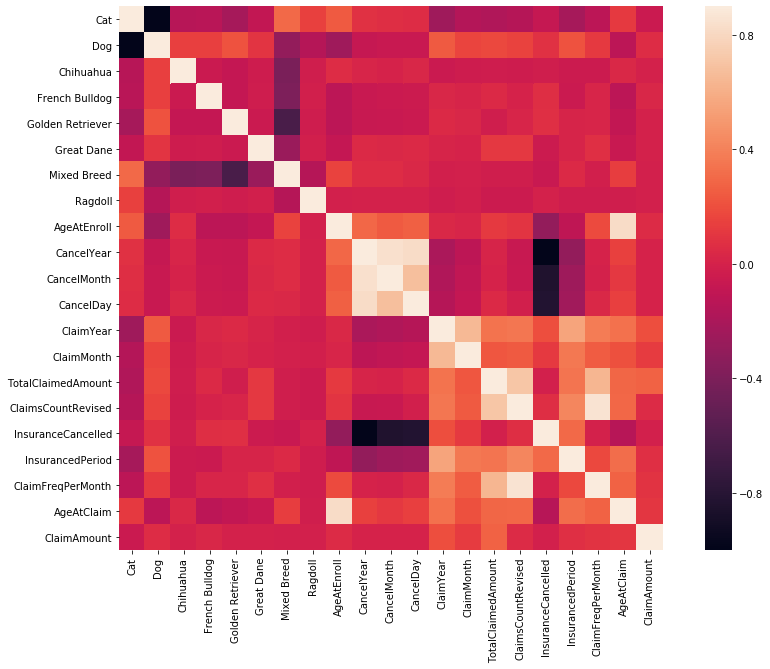

In [54]:
#claim_amount correlation matrix
corrmat = final_features_selected_zero.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, vmax=0.9, square=True)

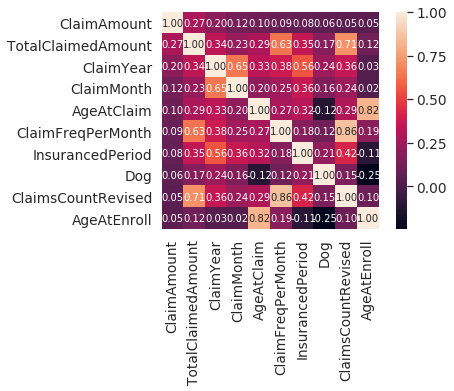

In [55]:

corrmat = final_features_selected_zero.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ClaimAmount')['ClaimAmount'].index
cm = np.corrcoef(final_features_selected_zero[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [0]:
# sns.set()
# cols = ['Cat', 'Dog', 'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll', 'AgeAtEnroll', 	'CancelYear',	'CancelMonth',	'CancelDay',	'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim', 'ClaimAmount' ]
# sns.pairplot(final_features_selected_zero[cols].sample(1000), height = 2.5)
# plt.show();

Feature and Label 

In [57]:
y =final_features_selected_zero['ClaimAmount']
selected_features = [ 'AgeAtEnroll', 	'CancelYear',	'CancelMonth', 'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim' ]
X = final_features_selected_zero[selected_features]
#X = final_features_selected_zero.drop(['ClaimAmount'], axis=1)
X.dtypes

AgeAtEnroll           float64
CancelYear              int64
CancelMonth             int64
ClaimYear               int64
ClaimMonth              int64
TotalClaimedAmount    float64
ClaimsCountRevised      int64
InsuranceCancelled      int64
InsurancedPeriod        int64
ClaimFreqPerMonth     float64
AgeAtClaim            float64
dtype: object

In [0]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
# Normalizing the dataset to make sure all the data is in range of 0 to 1 
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_rescaled = X_train #scaler.fit_transform(X_train)
X_test_rescaled = X_test #scaler.fit_transform(X_test)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [61]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_test, y_train)

ValueError: ignored

In [0]:
rf_random.best_params_
best_random = rf_random.best_estimator_

In [0]:
# randomForest = RandomForestRegressor()
# randomForest.fit(X_train_rescaled, y_train)
ydecpredRand = best_random.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredRand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredRand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredRand)))

In [0]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train_rescaled.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [0]:
NN_model.fit(X_train_rescaled, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

In [62]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train_rescaled, y_train)
y_pred_linear_reg = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_linear_reg))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_linear_reg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear_reg)))

Mean Absolute Error: 559.9832820068935
Mean Squared Error: 1644979.4905949833
Root Mean Squared Error: 1282.5675384146377


In [63]:
destree = tree.DecisionTreeRegressor()
destree.fit(X_train_rescaled, y_train)
ydecpredTree = destree.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredTree))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredTree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredTree)))

Mean Absolute Error: 631.2819023539669
Mean Squared Error: 2731779.364181779
Root Mean Squared Error: 1652.8095365715249


In [64]:
model = xgb.XGBRegressor()
model.fit(X_train_rescaled, y_train)
ypred_xgb_reg_pred = model.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred_xgb_reg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ypred_xgb_reg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ypred_xgb_reg_pred)))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 479.5183280400523
Mean Squared Error: 1412073.4698966881
Root Mean Squared Error: 1188.3069762888242


In [0]:
print(model.feature_importances_)
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(17)
   .plot(kind='barh'))

In [0]:
gradBoost = GradientBoostingRegressor()
gradBoost.fit(X_train_rescaled, y_train)
ydecpredRand = gradBoost.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredRand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredRand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredRand)))


# Test data preprocessing

In [0]:
pet_data_test = pd.merge(pet_data_df, extracted_features, how='inner' , on = 'PetId')
age_values_at_enrolled = pet_data_test.AgeAtEnroll.unique()
age_converted = [5,3,0.5,1,4,7,10,9,2,8,6,11,0.08,13,12]
for i in range(len(age_values_at_enrolled)):
  pet_data_test['AgeAtEnroll'].replace(to_replace = age_values_at_enrolled[i], value = age_converted[i] , inplace=True)
pet_data_test.head()

In [0]:
pet_data_test['EnrollYear'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).year
pet_data_test['EnrollMonth'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).month
pet_data_test['EnrollDay'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).day
pet_data_test['CancelYear'] = pd.DatetimeIndex(pet_data_test['CancelDate']).year
pet_data_test['CancelMonth'] = pd.DatetimeIndex(pet_data_test['CancelDate']).month
pet_data_test['CancelDay'] = pd.DatetimeIndex(pet_data_test['CancelDate']).day
pet_data_test['ClaimYear'] = '2019'
pet_data_test['ClaimMonth'] = '07'

# process columns, apply LabelEncoder to categorical features
cols = ['Species', 'Breed']
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(pet_data_test[c].values)) 
    pet_data_test[c] = lbl.transform(list(pet_data_test[c].values))
pet_data_test.head()
petId = pet_data_test['PetId']
selected_features.remove('ClaimAmount')
pet_data_test_final = pet_data_test[selected_features]
pet_data_test_final = pet_data_test_final.fillna(0)
pet_data_test_final['CancelYear'] = pet_data_test_final['CancelYear'].astype(int)
pet_data_test_final['CancelMonth'] = pet_data_test_final['CancelMonth'].astype(int)
pet_data_test_final['CancelDay'] = pet_data_test_final['CancelDay'].astype(int)
pet_data_test_final['ClaimYear'] = pet_data_test_final['ClaimYear'].astype(int)
pet_data_test_final['ClaimMonth'] = pet_data_test_final['ClaimMonth'].astype(int)

pet_data_test_final.head()
# Normalizing the dataset to make sure all the data is in range of 0 to 1 
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
pet_data_test_final_scaled = scaler.fit_transform(pet_data_test_final)

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
gradBoost = GradientBoostingRegressor()
gradBoost.fit(X_rescaled, y)
ypred_gradBoost = gradBoost.predict(pet_data_test_final_scaled)

In [0]:
submission = pd.DataFrame({
        "petId": petId,
        "CliamAmount": ypred_gradBoost
    })
from google.colab import files
submission.to_csv('Pet_claim_predicted_july.csv', index=False)